# Porfolio Optimization

## Contents


1.   Global Minimum Variance (GMV)
2.   Efficient Portfolio
3.   Efficient Frontier
4.   Tangency Portfolio



## Notes

- Variance

  - Variance measures the dispersion of an asset's returns around its mean (expected return). It measures individual asset risk.

  - Formula: for an assert with random return $r_i$ and expected return $\mu_i$: $\sigma_i^2=\text{Var}(r_i)=\mathbb{E}[(r_i-\mu_i)^2]$.

  - Higher variance → Higher risk (more volatile returns).


- Covariance

  - Covariance measures the directional relationship between two assets' returns. It tells whether they tend to move in the same direction (positive covariance) or opposite diretions (negative covariance).

  - Formula: for two assets $r_i$ and $r_j$: $\sigma_{ij}=\text{Cov}(r_i,r_j)=\mathbb{E}[(r_i-\mu_i)(r_j-\mu_j)]$.

  - Combining assets with negative/low covariance reduces overall portfolio risk.


- Portfolios

  - Assume $n$ assets with expected return $\mu$ and covariance matrix $\Sigma$.
  The return and variance of a portfolio that invests in these $n$ assets with weight $w$ are: $\mu_p=w^T \mu$ and $\sigma_p^2=w^T \Sigma w$.

  - Assume two portfolios of respective weights $w_1$ and $w_2$. The covariance between these two portfolios is $\rho_{12}=cov(w_1^T\mu,w_2^T\mu)=w_1^T\Sigma w_2$.


#### Reference:

https://letianzj.github.io/portfolio-management-one.html


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from datetime import datetime, date

### Load Data

In [2]:
# Load data
assets = [
    'AAPL',  # Apple
    'KO',    # Coca-Cola
    'DIS',   # Disney
    'XOM',   # Exxon Mobil
    'JPM',   # JPMorgan Chase
    'MCD',   # McDonald's
    'WMT',   # Walmart
]

hist_data = pd.DataFrame()
start_data = '2015-01-01'
end_data = '2017-12-31'
for i in range(len(assets)):
  asset = assets[i]
  data = pd.read_csv("data/" + asset + ".csv")
  mask1 = data['Date'] >= start_data
  mask2 = data['Date'] <= end_data
  data = data[mask1 & mask2]
  if i == 0:
    hist_data['Date'] = data['Date']
    hist_data[asset] = data['Adj Close']
  else:
    hist_data = pd.merge(hist_data, data[['Date', 'Adj Close']], on='Date', how='left')
    hist_data.rename(columns={'Adj Close': asset}, inplace=True)

# Check nan
assert hist_data.isna().sum().sum() == 0

hist_data.shape

(755, 8)

In [3]:
hist_data.head()

,Date,AAPL,KO,DIS,XOM,JPM,MCD,WMT
0,2015-01-02,100.216454,35.491245,87.376266,75.439079,54.462791,80.689468,75.466400
1,2015-01-05,97.393181,35.491245,86.099403,73.374931,52.771992,79.798302,75.246773
2,2015-01-06,97.402374,35.760750,85.642708,72.984848,51.403664,79.945404,75.826607
3,2015-01-07,98.768150,36.207142,86.518814,73.724373,51.482113,81.338379,77.838448
4,2015-01-08,102.563072,36.645096,87.413536,74.951500,52.632545,81.641197,79.481316


### Compute log returns, mean, variance and covariance

In [4]:
# Calculate historical log returns
cols = hist_data.columns[1:]
hist_return = np.log(hist_data[cols] / hist_data.shift()[cols])
hist_return.dropna(inplace=True)

In [5]:
hist_return.head()

,AAPL,KO,DIS,XOM,JPM,MCD,WMT
1,-0.028576,0.000000,-0.014721,-0.027743,-0.031537,-0.011106,-0.002915
2,0.000094,0.007565,-0.005318,-0.005330,-0.026271,0.001842,0.007676
3,0.013925,0.012405,0.010178,0.010082,0.001525,0.017274,0.026186
4,0.037703,0.012023,0.010288,0.016508,0.022100,0.003716,0.020886
5,0.001072,-0.011093,0.004892,-0.001411,-0.017540,-0.012262,-0.012457


In [6]:
# Find historical mean, covariance, and correlation
hist_mean = hist_return.mean(axis=0).to_frame()
hist_mean.columns = ['mu']
hist_cov = hist_return.cov()
hist_corr = hist_return.corr()

print(f"Historical average daily return: \n{hist_mean.transpose()}\n\n")
print(f"Historical daily return covariance: \n{hist_cov}\n\n")
print(f"Historical daily return correlation: \n{hist_corr}\n\n")

Historical average daily return: 
        AAPL        KO       DIS       XOM       JPM       MCD       WMT
mu  0.000652  0.000242  0.000238  0.000002  0.000816  0.000932  0.000293


Historical daily return covariance: 
          AAPL        KO       DIS       XOM       JPM       MCD       WMT
AAPL  0.000208  0.000032  0.000055  0.000051  0.000076  0.000044  0.000038
KO    0.000032  0.000065  0.000030  0.000033  0.000032  0.000035  0.000030
DIS   0.000055  0.000030  0.000138  0.000048  0.000072  0.000032  0.000031
XOM   0.000051  0.000033  0.000048  0.000132  0.000080  0.000036  0.000028
JPM   0.000076  0.000032  0.000072  0.000080  0.000180  0.000051  0.000038
MCD   0.000044  0.000035  0.000032  0.000036  0.000051  0.000101  0.000032
WMT   0.000038  0.000030  0.000031  0.000028  0.000038  0.000032  0.000150


Historical daily return correlation: 
          AAPL        KO       DIS       XOM       JPM       MCD       WMT
AAPL  1.000000  0.277773  0.324263  0.308124  0.390764  0.305937  

### Generate synthetic portfolios

Use Monte Carlo simulaton to construct 5,000 portfolios with random generated weights $w$.

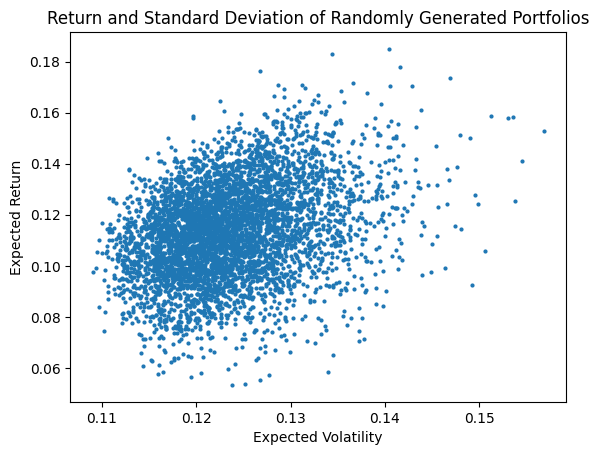

In [7]:
# Construct random portfolios
n_portfolios = 5000

# Results placeholders
port_returns = np.zeros(n_portfolios)
port_stds = np.zeros(n_portfolios)

for i in range(n_portfolios):
  w = np.random.random(len(assets)) # generate random weights
  w /= np.sum(w) # normalize so that weights sum equal to one
  port_return = np.dot(w.T, hist_mean.values) * 250 # annualize; 250 business days
  port_std = np.sqrt(np.dot(w.T, np.dot(hist_cov, w)) * 250) # annualize; 250 business days
  port_returns[i] = port_return.item()
  port_stds[i] = port_std.item()

# Plot
plt.plot(port_stds, port_returns, 'o',markersize=2)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Return and Standard Deviation of Randomly Generated Portfolios')
plt.show()

Some portfolios are superior to others, achieving higher returns at the cost of lower risks.

### Global Minimum Variance (GMV)

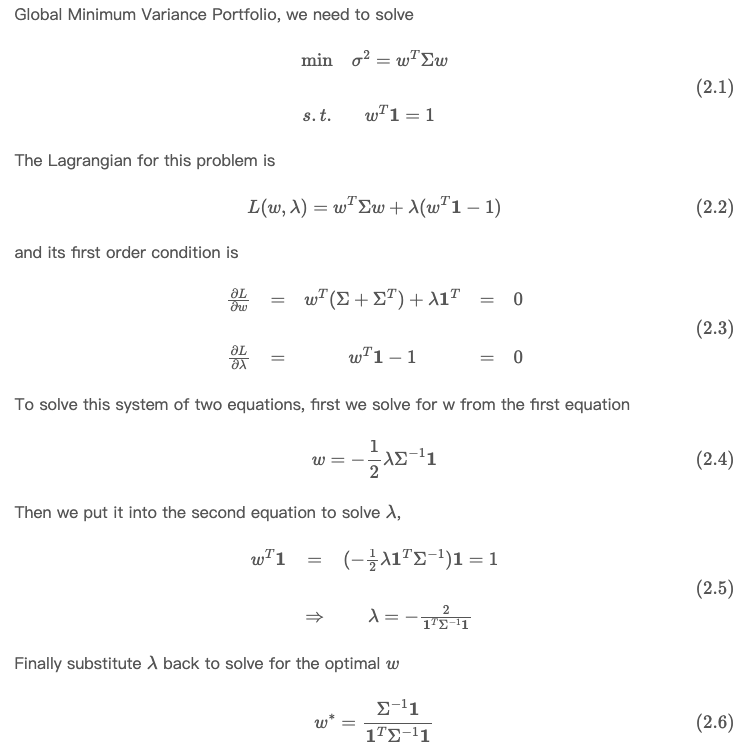

#### Closed-form of Global Minimum Variance (GMV)

In [8]:
# Closed-form of Global Minimum Variance (GMV)
hist_cov_inv = np.linalg.inv(hist_cov)
one_vec = np.ones(len(assets))
w_gmv = np.dot(hist_cov_inv, one_vec) / (np.dot(np.transpose(one_vec), np.dot(hist_cov_inv, one_vec)))
w_gmv_df = pd.DataFrame(data=w_gmv).transpose()
w_gmv_df.columns = assets
std_gmv = np.sqrt(np.dot(np.transpose(w_gmv), np.dot(hist_cov, w_gmv))) * np.sqrt(250)
print("GMV weights: \n", w_gmv_df, "\n")
print("GMV standard deviation: \n", std_gmv)

GMV weights: 
        AAPL        KO       DIS       XOM       JPM       MCD       WMT
0  0.037909  0.426967  0.125357  0.115102 -0.014228  0.179355  0.129538 

GMV standard deviation: 
 0.10748252656948809


#### Numerical solution: use Python quadratic solver

https://cvxopt.org/userguide/coneprog.html#cvxopt.solvers.qp

https://cvxopt.org/examples/book/portfolio.html

In [9]:
# Numerical solution
P = matrix(hist_cov.values)
q = matrix(np.zeros((len(assets), 1)))
A = matrix(1.0, (1, len(assets)))
b = matrix(1.0)

w_gmv_v2 = np.array(solvers.qp(P, q, A=A, b=b)['x'])
w_gmv_v2_df = pd.DataFrame(w_gmv_v2).transpose()
w_gmv_v2_df.columns = assets
std_gmv_v2 = np.sqrt(np.dot(np.transpose(w_gmv_v2), np.dot(hist_cov, w_gmv_v2))) * np.sqrt(250)
print("GMV weights: \n", w_gmv_v2_df, "\n")
print("GMV standard deviation: \n", std_gmv_v2.item())

GMV weights: 
        AAPL        KO       DIS       XOM       JPM       MCD       WMT
0  0.037909  0.426967  0.125357  0.115102 -0.014228  0.179355  0.129538 

GMV standard deviation: 
 0.10748252656948813


Both methods yield the same optimal weights.

### Efficient Portfolio


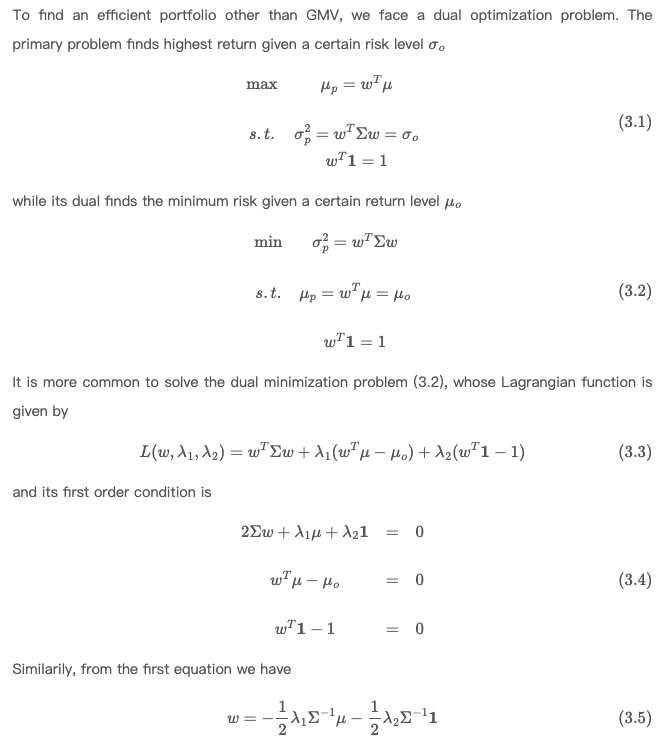

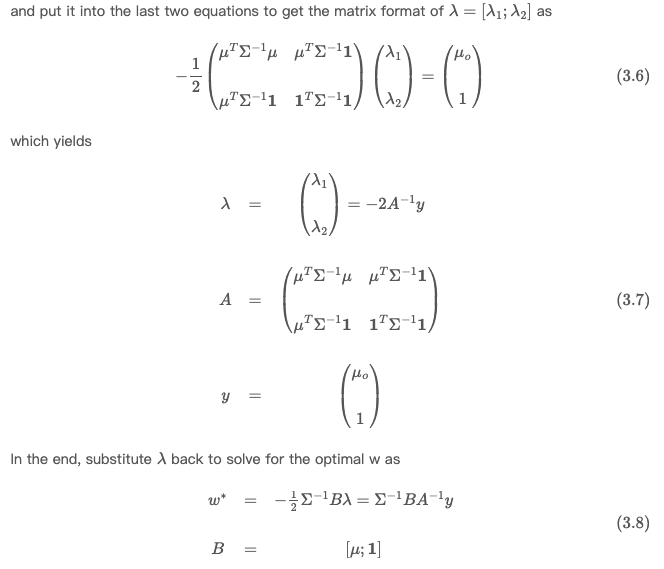

In [13]:
# Closed-form solution
mu_o = hist_mean.max().item()

A = np.matrix([[np.dot(hist_mean.T, np.dot(hist_cov_inv, hist_mean)).item(), np.dot(hist_mean.T, np.dot(hist_cov_inv, one_vec)).item()],
               [np.dot(hist_mean.T, np.dot(hist_cov_inv, one_vec)).item(), np.dot(one_vec.T, np.dot(hist_cov_inv, one_vec))]])
B = np.hstack([hist_mean.values, one_vec.reshape(len(assets), 1)])
y = np.matrix([mu_o, 1]).T

w_max_return = np.dot(np.dot(np.dot(hist_cov_inv, B), np.linalg.inv(A)), y)
w_max_return_df = pd.DataFrame(w_max_return).T
w_max_return_df.columns = assets

print(f"Maximum historical return: {mu_o} \n")
print(f"Minimum risk portfolio weight at given maximum return level: \n {w_max_return_df}")

Maximum historical return: 0.0009316820020987081 

Minimum risk portfolio weight at given maximum return level: 
        AAPL       KO       DIS      XOM       JPM       MCD       WMT
0  0.103271  0.18633 -0.010098 -0.23826  0.252619  0.640554  0.065584


In [14]:
# Numerical solution
P = matrix(hist_cov.values)
q = matrix(np.zeros((len(assets), 1)))
A = matrix(np.hstack([hist_mean.values, one_vec.reshape(len(assets), 1)]).transpose())
b = matrix([mu_o, 1])

w_max_return_v2 = np.array(solvers.qp(P, q, A=A, b=b)['x'])
w_max_return_v2_df = pd.DataFrame(w_max_return).transpose()
w_max_return_v2_df.columns = assets
w_max_return_v2_df

,AAPL,KO,DIS,XOM,JPM,MCD,WMT
0,0.103271,0.18633,-0.010098,-0.23826,0.252619,0.640554,0.065584


### Efficient Frontier

The previous section identifies the minimum-risk portfolio for a specific target return. By evaluating this across all possible return levels, we derive a collection of optimal portfolios, forming what is called the efficient frontier.

Optimal portfolios:
- The highest expected return for a given level of risk, or
- The lowest risk for a given level of expected return

Portfolios that lie below the Efficient Frontier are suboptimal (either lower return for the same risk or higher risk for the same return).




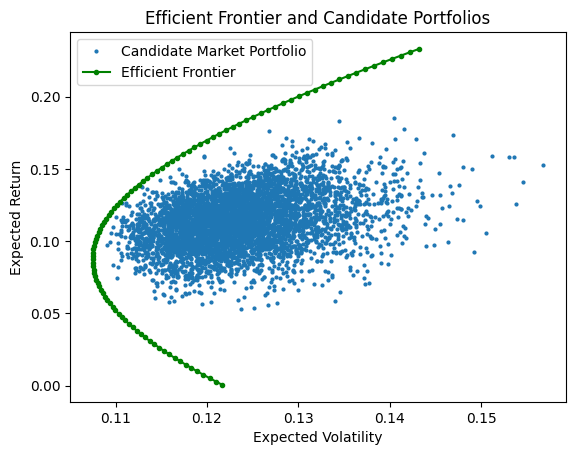

In [15]:
# Efficient frontier
N = 100 # traverse N target returns
ef_left = hist_mean.min().item()  # minimum return
ef_right = hist_mean.max().item() # maximum return
target_returns = np.linspace(ef_left, ef_right, N) # N target returns
optimal_weights = [solvers.qp(P, q, A=A, b=matrix([mu_target, 1]))['x'] for mu_target in target_returns] # QP solver

ef_returns = [(np.dot(w.T, hist_mean.values)*250).item() for w in optimal_weights]
ef_risks = [np.sqrt(np.dot(w.T, np.dot(hist_cov, w)) * 250).item() for w in optimal_weights]

plt.plot(port_stds, port_returns, 'o', markersize=2, label='Candidate Market Portfolio')
plt.plot(ef_risks, ef_returns, '-o', color='green', markersize=3, label='Efficient Frontier')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier and Candidate Portfolios')
plt.legend(loc='best')
plt.show()

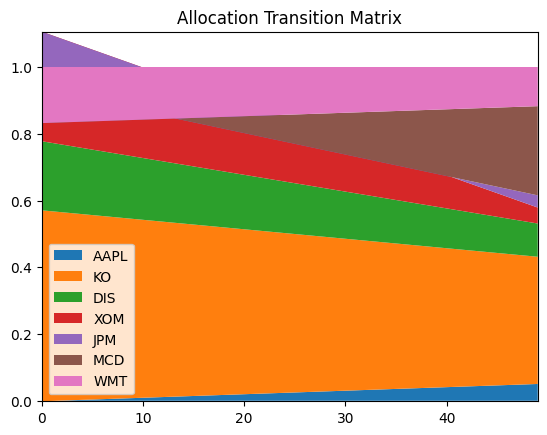

In [35]:
# Visualize the weight allocation transition matrix of efficient portfolios from low returns to high returns
transition_data = pd.DataFrame(optimal_weights) # N_x_7
transition_data.columns = assets
plt.stackplot(range(50), transition_data.iloc[:50,:].T, labels=assets)
plt.legend(loc='best')
plt.margins(0, 0)
plt.title('Allocation Transition Matrix')
plt.show()

### Tangency Portfolio

Tangency portfolio maximizes Sharpe Ratio.

Sharpe Ratio = $\frac{R_p-R_f}{\sigma_p}$, where $R_p$ is portfolio return, $R_f$ is risk-free rate, and $\sigma_p$ is the standard deviation of portfolio returns.

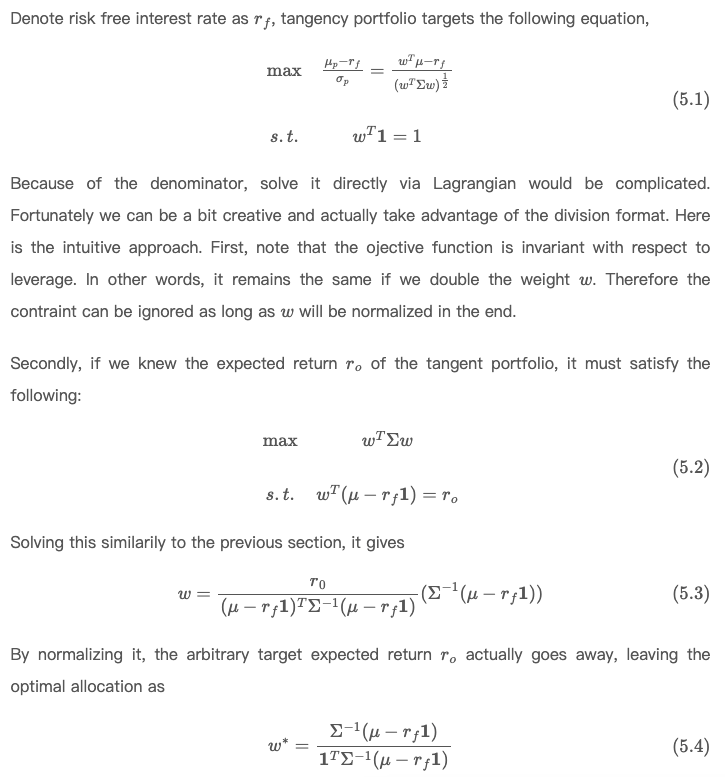

In [47]:
# Closed-form solution
r_f = 0.01
w_sharpe = np.dot(hist_cov_inv, hist_mean.values-r_f/250) / np.dot(one_vec, np.dot(hist_cov_inv, hist_mean.values-r_f/250))
w_sharpe_df = pd.DataFrame(w_sharpe).T
w_sharpe_df.columns = assets
mu_sharpe = np.dot(w_sharpe.T, hist_mean.values) * 250 # annualized
std_sharpe = np.sqrt(np.dot(w_sharpe.T, np.dot(hist_cov, w_sharpe))) * np.sqrt(250) # annulaized
sharpe_ratio = (mu_sharpe - r_f) / std_sharpe

print(f"Weights of tangency portfolio:\n {w_sharpe_df} \n")
print(f"Expected return of tangency portfolio:\n {mu_sharpe.item()} \n")
print(f"Standard deviation of tangency portfolio:\n {std_sharpe.item()} \n")
print(f"Sharpe ratio of tangency portfolio:\n {sharpe_ratio.item()} \n")

Weights of tangency portfolio:
        AAPL        KO       DIS       XOM       JPM       MCD       WMT
0  0.194734 -0.150399 -0.199644 -0.732727  0.626024  1.285921 -0.023909 

Expected return of tangency portfolio:
 0.43578633080961776 

Standard deviation of tangency portfolio:
 0.25120957385416703 

Sharpe ratio of tangency portfolio:
 1.6949446801609422 



In [52]:
# Numerical solution to (5.1)
from scipy.optimize import minimize

func = lambda w: -1 * (np.dot(w.T, hist_mean.values*250)-r_f) / np.sqrt(np.dot(w.T, np.dot(hist_cov*250, w)))
cons = ({'type': 'eq', 'fun': lambda w: np.dot(w.T, one_vec)-1})
res = minimize(func, w_gmv, method='SLSQP', constraints=cons)
w_sharpe_v2 = res['x']
w_sharpe_v2_df = pd.DataFrame(w_sharpe_v2).T
w_sharpe_v2_df.columns = assets
mu_sharpe_v2 = np.dot(w_sharpe_v2.T, hist_mean.values) * 250 # annualized
std_sharpe_v2 = np.sqrt(np.dot(w_sharpe_v2.T, np.dot(hist_cov, w_sharpe_v2))) * np.sqrt(250) # annulaized
sharpe_ratio_v2 = (mu_sharpe_v2 - r_f) / std_sharpe_v2
print(f"Weights of tangency portfolio:\n {w_sharpe_v2_df} \n")
print(f"Expected return of tangency portfolio:\n {mu_sharpe_v2.item()} \n")
print(f"Standard deviation of tangency portfolio:\n {std_sharpe_v2.item()} \n")
print(f"Sharpe ratio of tangency portfolio:\n {sharpe_ratio_v2.item()} \n")

Weights of tangency portfolio:
        AAPL        KO       DIS       XOM       JPM    MCD       WMT
0  0.194699 -0.150522 -0.199647 -0.732666  0.626107  1.286 -0.023972 

Expected return of tangency portfolio:
 0.435803707236318 

Standard deviation of tangency portfolio:
 0.2512198271714751 

Sharpe ratio of tangency portfolio:
 1.6949446706914464 

